# Imports

In [0]:
import zipfile
import numpy as np
import pandas as pd
import os
import tqdm
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt
import csv

In [0]:
from google.colab import drive
GOOGLE_DRIVE_MOUNT = "/content/gdrive"
drive.mount(GOOGLE_DRIVE_MOUNT)

# Download data from Kaggle

In [35]:
# we need to use python 3 version of Kaggle!
# remove python 2 version with `pip uninstall kaggle`
! pip3 install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.0)


In [36]:
# get <token> from https://www.kaggle.com/<user>/account, click "Create New API Token", open json file
! KAGGLE_USERNAME="bosha7" KAGGLE_KEY="5ad2af8e7aeadb331fff92431a54d056" kaggle competitions download -c quickdraw-doodle-recognition -f train_simplified.zip

train_simplified.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
# open zip file, will read everything from it
zf = zipfile.ZipFile("train_simplified.zip")

# Data generators from disk (no need to store in RAM)

In [38]:
class_labels = map(lambda x: x.replace(".csv", ""), zf.namelist())
class_labels[:5]

['fence', 'yoga', 'horse', 'sandwich', 'cat']

In [0]:
# loop through file eternally
def get_eternal_csv_generator(fn, debug=False):
    while True:
        with zf.open(fn) as f:
            f.readline()  # skip header
            for line in csv.reader(f, delimiter=',', quotechar='"'):
                yield line[1], line[5]
            if debug:
                print fn, "is done, starting from the beginning..."

In [0]:
def raw_batch_generator(batch_size, debug=False):
    generators = np.array([get_eternal_csv_generator(fn, debug) for fn in zf.namelist()])
    while True:
        random_indices = np.random.randint(0, len(generators), size=batch_size)
        yield [gen.next() for gen in generators[random_indices]]

# Images generator

In [0]:
# copy-paste from https://www.kaggle.com/jpmiller/image-based-cnn

import ast
from PIL import Image, ImageDraw
import cv2

IMG_SIZE = 128

# faster conversion function
def draw_it(strokes):
    img = 255 * np.ones((256, 256), np.uint8)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 0, 3)
    return cv2.resize(img, (IMG_SIZE, IMG_SIZE))

In [0]:
from keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(
    rotation_range=90,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True,
    fill_mode='constant',
    cval=255
)

def images_and_labels_generator_augmentation(batch_size):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            image = draw_it(e[0])
            image = np.tile(np.expand_dims(image, axis=2), (1, 1, 3))
            for s in range(2):
              batch_images.append(image_gen.random_transform(image)[:, :, 0])
              batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        yield batch_images, batch_labels

In [0]:
def images_and_labels_generator(batch_size):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(draw_it(e[0]))
            batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        yield batch_images, batch_labels

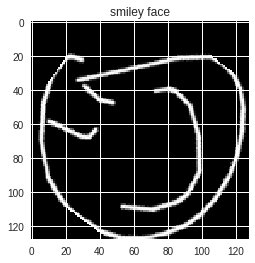

In [44]:
b = images_and_labels_generator_augmentation(32).next()
plt.imshow(b[0][10, :, :])
plt.title(b[1][10])
plt.show()

# Augmentation example

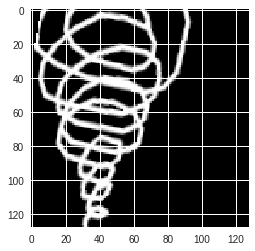

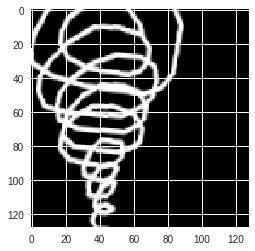

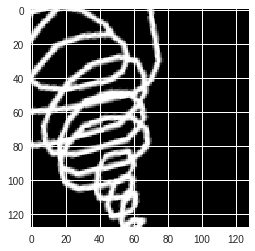

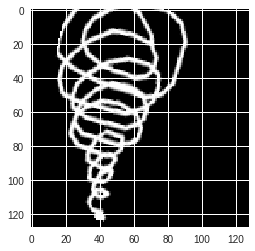

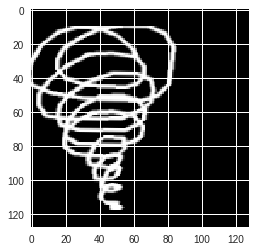

In [25]:
from keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='constant',
    cval=255
)

image = b[0][10, :, :]

# add 3 channels to image
image = np.tile(np.expand_dims(image, axis=2), (1, 1, 3))

# 5 random augmentations
for _ in range(5):
    plt.imshow(image_gen.random_transform(image)[:, :, 0])
    plt.show()

# Train simple network

In [0]:
import tensorflow as tf
import keras
from keras import backend as K

In [0]:
# reset graph when you change architecture!
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [47]:
NUM_CLASSES = len(class_labels)
class_to_idx = {c: idx for idx, c in enumerate(class_labels)}
class_to_idx.items()[:5]

[('snowman', 134),
 ('eyeglasses', 254),
 ('ceiling fan', 18),
 ('camel', 90),
 ('stove', 119)]

In [0]:
def train_iterator(batch_size):
    for batch in images_and_labels_generator(batch_size):
        images = batch[0].astype('float32')
        images = images/255-0.5
        ### YOUR CODE HERE: normalize images!
        images = np.expand_dims(images, -1)
        labels = keras.utils.to_categorical(map(class_to_idx.get, batch[1]), NUM_CLASSES)
        yield images, labels

In [0]:
def train_iterator_augmentation(batch_size):
    for batch in images_and_labels_generator_augmentation(batch_size):
        images = batch[0].astype('float32')
        images = images/255-0.5
        ### YOUR CODE HERE: normalize images!
        images = np.expand_dims(images, -1)
        labels = keras.utils.to_categorical(map(class_to_idx.get, batch[1]), NUM_CLASSES)
        yield images, labels

In [50]:
sample = train_iterator(32).next()
print sample[0].shape
print sample[1].shape

(32, 128, 128, 1)
(32, 340)


In [0]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D, Reshape, DepthwiseConv2D, Flatten, Dense, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization
from keras.applications import MobileNet
from keras.layers.advanced_activations import LeakyReLU, ReLU, ELU

MODEL Mobilnet
Данная модель на размере батча в 150 на 15 эпохах loss: 2.0341 - categorical_accuracy: 0.5128 - top_3_accuracy: 0.7189
В данной модели была практически воспроизведена архитектура сети MobilNet, при большем батче на большем количестве эпох модель начинала переобучиваться, при добавлении Dropout проблема частично решалась
Скор на кэгле около 0.6

In [0]:
  def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()  
    
    model.add(Conv2D(32,strides=2, kernel_size=(3, 3), padding='same', input_shape=(IMG_SIZE,IMG_SIZE, 1)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(ZeroPadding2D())
    model.add(DepthwiseConv2D(kernel_size=(3,3)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(64, kernel_size=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(ZeroPadding2D())
    model.add(DepthwiseConv2D(kernel_size=(3,3),strides=2))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(128, kernel_size=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(ZeroPadding2D())
    model.add(DepthwiseConv2D(kernel_size=(3,3)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(128,kernel_size=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(ZeroPadding2D())
    model.add(DepthwiseConv2D(kernel_size=(3,3),strides=2))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(256, kernel_size=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(ZeroPadding2D())
    model.add(DepthwiseConv2D(kernel_size=(3,3),strides=2))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(512, kernel_size=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(ZeroPadding2D())
    model.add(DepthwiseConv2D(kernel_size=(3,3)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(512, kernel_size=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(ZeroPadding2D())
    model.add(DepthwiseConv2D(kernel_size=(3,3)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(512, kernel_size=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(ZeroPadding2D())
    model.add(DepthwiseConv2D(kernel_size=(3,3)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(512, kernel_size=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(ZeroPadding2D())
    model.add(DepthwiseConv2D(kernel_size=(3,3)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(512, kernel_size=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(ZeroPadding2D())
    model.add(DepthwiseConv2D(kernel_size=(3,3)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(ZeroPadding2D())
    model.add(DepthwiseConv2D(kernel_size=(3,3),strides=2))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(1024, kernel_size=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(ZeroPadding2D())
    model.add(DepthwiseConv2D(kernel_size=(3,3)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(1024, kernel_size=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(GlobalAveragePooling2D())
    model.add(Reshape((1,1,1024)))
    model.add(Dropout(0.5))
    model.add(Conv2D(NUM_CLASSES, kernel_size=(1, 1), padding='same'))
    model.add(Activation('softmax'))
    model.add(Reshape((NUM_CLASSES,)))
    
    return model

Данная модель на размере батча в 150 на 15 эпохах  loss 3.4064 - categorical_accuracy: 0.2525 - top_3_accuracy: 0.4415
Из-за недостаточного количества фильтров, свертка не могла находить нужные закономерности
Также по сравнению с лучшей моделью здесь была использована другая функция активации

In [0]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()


    ### YOUR CODE HERE: replace with a better model! Batch normalization really helps!
    
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, kernel_size=(3,3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(BatchNormalization())
    
    model.add(Conv2D(256, kernel_size=(3,3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(BatchNormalization())
    
    model.add(Conv2D(512, kernel_size=(3,3), padding='same'))
    model.add(LeakyReLU(0.1))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.2))
    
    model.add(Dense(680))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(NUM_CLASSES))
    model.add(Activation('softmax'))

    
    return model

**MODEL BEST**
Данная модель на размере батча в 150 на 15 эпохах loss: 2.0898 - categorical_accuracy: 0.5114 - top_3_accuracy: 0.7165
на размере батча в 340 на 100 эпохах 

Закомментированные строчки также были использованы в ходе эксперимента, и оказалось, что пулинг, который уплотняет карту признаков и делает изображение более абстрактным(убирает некую подробность с кажды разом), лучше использовать после каждой второй конволюции.
В конволюции следует последовательно увеличивать количество фильтров, также можно оставлять это количество неизменным на 2 слоя. Качество также увеличило то, что с последних слоев была убрана батчнормализация. 
Данная функция активация может давать отрицательные значения, способствует более быстрому схождению градиента. 
И были добавлены Dropout после пулинг слоев для избежания проблемы переобучения

In [0]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()


    ### YOUR CODE HERE: replace with a better model! Batch normalization really helps!
    
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(ELU(alpha=0.5))
    model.add(BatchNormalization())
    #model.add(Dropout(0.2))
    
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same',strides=2))
    model.add(ELU(alpha=0.5))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, kernel_size=(3,3), padding='same'))
    model.add(ELU(alpha=0.5))
    model.add(BatchNormalization())
    
    model.add(Conv2D(128, kernel_size=(3,3), padding='same'))
    model.add(ELU(alpha=0.5))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
    model.add(ELU(alpha=0.5))
    model.add(BatchNormalization())
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.2))
    
    model.add(Conv2D(512, kernel_size=(3, 3), padding='same'))
    model.add(ELU(alpha=0.5))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    #model.add(Conv2D(512, kernel_size=(3, 3), padding='same'))
    #model.add(ELU(alpha=0.5))
    #model.add(BatchNormalization())
    
    model.add(Conv2D(1024, kernel_size=(3, 3), padding='same'))
    model.add(ELU(alpha=0.5))
    model.add(BatchNormalization())
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.2))
        
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.3))
    
    model.add(Dense(680))
    model.add(ELU(alpha=0.5))
    #model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(NUM_CLASSES))
    model.add(Activation('softmax'))
    
    return model

In [2]:
# describe model
s = reset_tf_session()  # clear default graph
model = make_model()
model.summary()

NameError: ignored

In [0]:
# custom metrics we need
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

Для экспериментов с аугментацией размер батча пришлось уменьшить до 150 не хватало памяти и рассматривать результат на 15 эпохе

In [56]:
BATCH_SIZE = 340 #150 для сравнительных тестов с аугментацией и архитектурой
STEPS_PER_EPOCH = 100
EPOCHS = 100 #15 

s = reset_tf_session()  # clear default graph
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),  # gradient clipping just in case
    metrics=[categorical_accuracy, top_3_accuracy]  # report top 3 accuracy, correlates with MAP@3!
)

Exception tensorflow.python.framework.errors_impl.CancelledError: CancelledError() in <bound method _Callable.__del__ of <tensorflow.python.client.session._Callable object at 0x7f4f19f3a610>> ignored


In [0]:
# for saving the model after every epoch
from keras.models import save_model

class ModelSaveCallback(keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

In [0]:
import os
GOOGLE_DRIVE_ROOT = GOOGLE_DRIVE_MOUNT + "/" + filter(lambda x: x[0] != '.', os.listdir(GOOGLE_DRIVE_MOUNT))[0]
print GOOGLE_DRIVE_ROOT

# will save checkpoints to Google Drive
CHECKPOINT_TEMPLATE = GOOGLE_DRIVE_ROOT + "/model_{}"
print CHECKPOINT_TEMPLATE

In [0]:
last_finished_epoch = 0

# you can continue from snapshot!!!
#from keras.models import load_model
#s = reset_tf_session()
#last_finished_epoch = 91
#model = load_model("model_{}".format(last_finished_epoch), 
#                  custom_objects={"top_3_accuracy": top_3_accuracy})

In [60]:
#best model с аугментацией
model.fit_generator(
    train_iterator_augmentation(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback("model_{}")],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/15
100/100 [==============================] - 156s 2s/step - loss: 5.5902 - categorical_accuracy: 0.0156 - top_3_accuracy: 0.0397
Model saved in model_0
Epoch 2/15
100/100 [==============================] - 154s 2s/step - loss: 5.1846 - categorical_accuracy: 0.0346 - top_3_accuracy: 0.0815
Model saved in model_1
Epoch 3/15
100/100 [==============================] - 154s 2s/step - loss: 4.8601 - categorical_accuracy: 0.0591 - top_3_accuracy: 0.1308
Model saved in model_2
Epoch 4/15
100/100 [==============================] - 155s 2s/step - loss: 4.6069 - categorical_accuracy: 0.0880 - top_3_accuracy: 0.1876
Model saved in model_3
Epoch 5/15
100/100 [==============================] - 154s 2s/step - loss: 4.3614 - categorical_accuracy: 0.1153 - top_3_accuracy: 0.2331
Model saved in model_4
Epoch 6/15
100/100 [==============================] - 155s 2s/step - loss: 4.0880 - categorical_accuracy: 0.1497 - top_3_accuracy: 0.2889
Model saved in model_5
Epoch 7/15
100/100 [==============

С аугментацией после 15 эпохи loss: 2.8621 - categorical_accuracy: 0.3511 - top_3_accuracy: 0.5525, также увеличилось время, т.к стало больше изображений из-за поворотов и различных преобразований с данными

Без аугментации после 15 эпохи loss: 2.0898 - categorical_accuracy: 0.5114 - top_3_accuracy: 0.7165

Также когда размер батча был 340 после 15 эпохи loss 1.7281 categorical_accuracy: 0.5852 - top_3_accuracy: 0.7799, т.е больший размер батча давал лучшее качество

In [62]:
# best model без аугментации
model.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback("model_{}")],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/15
100/100 [==============================] - 70s 695ms/step - loss: 5.2491 - categorical_accuracy: 0.0361 - top_3_accuracy: 0.0834
Model saved in model_0
Epoch 2/15
100/100 [==============================] - 64s 641ms/step - loss: 4.4260 - categorical_accuracy: 0.1033 - top_3_accuracy: 0.2168
Model saved in model_1
Epoch 3/15
100/100 [==============================] - 64s 641ms/step - loss: 3.9473 - categorical_accuracy: 0.1673 - top_3_accuracy: 0.3143
Model saved in model_2
Epoch 4/15
100/100 [==============================] - 64s 641ms/step - loss: 3.5391 - categorical_accuracy: 0.2269 - top_3_accuracy: 0.4056
Model saved in model_3
Epoch 5/15
100/100 [==============================] - 64s 641ms/step - loss: 3.2745 - categorical_accuracy: 0.2747 - top_3_accuracy: 0.4697
Model saved in model_4
Epoch 6/15
100/100 [==============================] - 64s 640ms/step - loss: 3.0267 - categorical_accuracy: 0.3195 - top_3_accuracy: 0.5173
Model saved in model_5
Epoch 7/15
100/100 [==

In [79]:
#модель с другой архитектурой 
model.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback("model_{}")],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/15
100/100 [==============================] - 52s 516ms/step - loss: 5.6828 - categorical_accuracy: 0.0157 - top_3_accuracy: 0.0395
Model saved in model_0
Epoch 2/15
100/100 [==============================] - 48s 480ms/step - loss: 4.7095 - categorical_accuracy: 0.0743 - top_3_accuracy: 0.1572
Model saved in model_1
Epoch 3/15
100/100 [==============================] - 48s 479ms/step - loss: 3.9115 - categorical_accuracy: 0.1643 - top_3_accuracy: 0.3145
Model saved in model_2
Epoch 4/15
100/100 [==============================] - 48s 479ms/step - loss: 3.4206 - categorical_accuracy: 0.2382 - top_3_accuracy: 0.4235
Model saved in model_3
Epoch 5/15
100/100 [==============================] - 48s 481ms/step - loss: 3.0926 - categorical_accuracy: 0.2997 - top_3_accuracy: 0.5023
Model saved in model_4
Epoch 6/15
100/100 [==============================] - 48s 478ms/step - loss: 2.8899 - categorical_accuracy: 0.3323 - top_3_accuracy: 0.5406
Model saved in model_5
Epoch 7/15
100/100 [==

In [0]:
# fit the model with our eternal generator! лучшая модель на батче = 340 100 эпох 91 модель
model.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback("model_{}")],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Exception tensorflow.python.framework.errors_impl.CancelledError: CancelledError() in <bound method _Callable.__del__ of <tensorflow.python.client.session._Callable object at 0x7f50a4fe0b90>> ignored


Epoch 1/100
100/100 [==============================] - 154s 2s/step - loss: 4.9049 - categorical_accuracy: 0.0635 - top_3_accuracy: 0.1395
Model saved in model_0
Epoch 2/100
100/100 [==============================] - 145s 1s/step - loss: 3.8057 - categorical_accuracy: 0.1905 - top_3_accuracy: 0.3475
Model saved in model_1
Epoch 3/100
100/100 [==============================] - 145s 1s/step - loss: 3.2039 - categorical_accuracy: 0.2867 - top_3_accuracy: 0.4802
Model saved in model_2
Epoch 4/100
100/100 [==============================] - 145s 1s/step - loss: 2.7981 - categorical_accuracy: 0.3614 - top_3_accuracy: 0.5696
Model saved in model_3
Epoch 5/100
100/100 [==============================] - 145s 1s/step - loss: 2.5192 - categorical_accuracy: 0.4181 - top_3_accuracy: 0.6275
Model saved in model_4
Epoch 6/100
100/100 [==============================] - 145s 1s/step - loss: 2.3579 - categorical_accuracy: 0.4535 - top_3_accuracy: 0.6617
Model saved in model_5
Epoch 7/100
100/100 [=======

ResourceExhaustedError: ignored

# Score test set

In [0]:
# download test set
! KAGGLE_USERNAME="bosha7" KAGGLE_KEY="5ad2af8e7aeadb331fff92431a54d056" kaggle competitions download -c quickdraw-doodle-recognition -f test_simplified.csv

 93% 55.0M/59.0M [00:00<00:00, 64.8MB/s]
100% 59.0M/59.0M [00:00<00:00, 127MB/s] 


In [0]:
def test_csv_iterator(batch_size):
    with open("test_simplified.csv", "r") as f:
        batch_keys = []
        batch_images = []
        f.readline()  # skip header
        for line in csv.reader(f, delimiter=',', quotechar='"'):
            batch_keys.append(line[0])
            batch_images.append(draw_it(line[2]))
            if len(batch_images) == batch_size:
                batch_images = np.stack(batch_images, axis=0)
                batch_images = np.expand_dims(batch_images, -1)
                batch_images = batch_images.astype('float32')
                batch_images = batch_images/255-0.5
                ### YOUR CODE HERE: normalize batch_images the same way as during training!
                yield batch_keys, batch_images
                batch_keys = []
                batch_images = []
        if batch_images:  # last batch
            batch_images = np.stack(batch_images, axis=0)
            batch_images = np.expand_dims(batch_images, -1)
            batch_images = batch_images.astype('float32')
            batch_images = batch_images/255-0.5
            ### YOUR CODE HERE: normalize batch_images the same way as during training!
            yield batch_keys, batch_images

In [0]:
! wc -l test_simplified.csv

112200 test_simplified.csv


In [0]:
with open("submission.csv", "w", buffering=1*1024*1024) as f:
    f.write("key_id,word\n")
    for batch_keys, batch_images in tqdm.tqdm(test_csv_iterator(BATCH_SIZE), total=np.ceil(112200./BATCH_SIZE)):
        probas = model.predict_proba(batch_images, BATCH_SIZE)
        top_3_classes = np.argsort(probas, axis=1)[:, [-1, -2, -3]]
        labels = map(lambda x: " ".join("_".join(class_labels[idx].split()) for idx in x), top_3_classes)
        for key, labels in zip(batch_keys, labels):
            f.write(key + "," + labels + "\n")

100%|██████████| 330/330.0 [04:06<00:00,  1.54s/it]


In [0]:

! wc -l submission.csv

112200 submission.csv


In [0]:
# submit to kaggle
! KAGGLE_USERNAME="bosha7" KAGGLE_KEY="5ad2af8e7aeadb331fff92431a54d056" kaggle competitions submit quickdraw-doodle-recognition -f submission.csv -m "My precious"

100% 4.40M/4.40M [00:04<00:00, 1.12MB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge